# **CARAVAN INSURANCE CHALLENGE**

By Group 6

*   Arshpreet Singh Bagga - 291013
*   Bikramadityya Guho - 291017
*   Jumbish S Dang - 291032
*   Apurv - 291049
*   Anuj Sharma - 291070

## **Importing the Libraries and Installations**



In [323]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve

import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [324]:
pip install optuna

In [325]:
pip install scikit-optimize

In [326]:
# 1.1 Import optuna integration with lightgbm
# Install as: conda install -c conda-forge optuna
import optuna.integration.lightgbm as lgbm

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [327]:
def plot_profit_curve(name, df_scores):
    plt.plot(df_scores["cum_profit"].values, linewidth=1, label=name + " Profit curve")
    plt.plot([0, 0], [0, 1], 'k--')
    plt.legend(loc="lower left")
    plt.xlabel('Number of test instances', fontsize=16)
    plt.ylabel('Profit', fontsize=16)
    plt.grid(True)

### **Loading Data**

In [328]:
from google.colab import files
uploaded = files.upload()

Saving caravan-insurance-challenge.csv to caravan-insurance-challenge (5).csv


In [329]:
df = pd.read_csv('caravan-insurance-challenge.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 0 to 9821
Data columns (total 87 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ORIGIN    9822 non-null   object
 1   MOSTYPE   9822 non-null   int64 
 2   MAANTHUI  9822 non-null   int64 
 3   MGEMOMV   9822 non-null   int64 
 4   MGEMLEEF  9822 non-null   int64 
 5   MOSHOOFD  9822 non-null   int64 
 6   MGODRK    9822 non-null   int64 
 7   MGODPR    9822 non-null   int64 
 8   MGODOV    9822 non-null   int64 
 9   MGODGE    9822 non-null   int64 
 10  MRELGE    9822 non-null   int64 
 11  MRELSA    9822 non-null   int64 
 12  MRELOV    9822 non-null   int64 
 13  MFALLEEN  9822 non-null   int64 
 14  MFGEKIND  9822 non-null   int64 
 15  MFWEKIND  9822 non-null   int64 
 16  MOPLHOOG  9822 non-null   int64 
 17  MOPLMIDD  9822 non-null   int64 
 18  MOPLLAAG  9822 non-null   int64 
 19  MBERHOOG  9822 non-null   int64 
 20  MBERZELF  9822 non-null   int64 
 21  MBERBOER  9822

In [330]:
df. head()

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## **Pre-Processing**

In [331]:
df.ORIGIN.value_counts()

train    5822
test     4000
Name: ORIGIN, dtype: int64

In [332]:
df.CARAVAN.value_counts()

0    9236
1     586
Name: CARAVAN, dtype: int64

In [333]:
df.nunique()

ORIGIN       2
MOSTYPE     40
MAANTHUI     9
MGEMOMV      6
MGEMLEEF     6
            ..
APLEZIER     3
AFIETS       5
AINBOED      3
ABYSTAND     3
CARAVAN      2
Length: 87, dtype: int64

In [334]:
df.isnull().values.any()

False

In [335]:
X_train = df[df['ORIGIN']=='train']
X_test = df[df['ORIGIN']=='test']
X_train.pop('ORIGIN')
X_test.pop('ORIGIN')
y_train=X_train.pop('CARAVAN')
y_test=X_test.pop('CARAVAN')

## **Visualization**

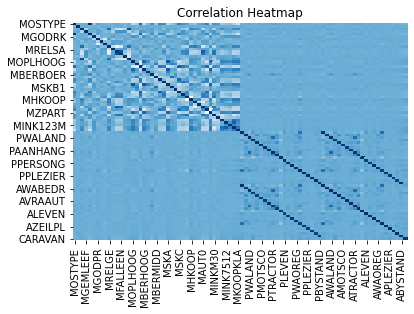

In [336]:
ax= plt.axes()
_=sns.heatmap(df.drop(columns=['ORIGIN']).corr(),cmap='Blues',cbar=None,ax=ax)
_=ax.set_title('Correlation Heatmap')

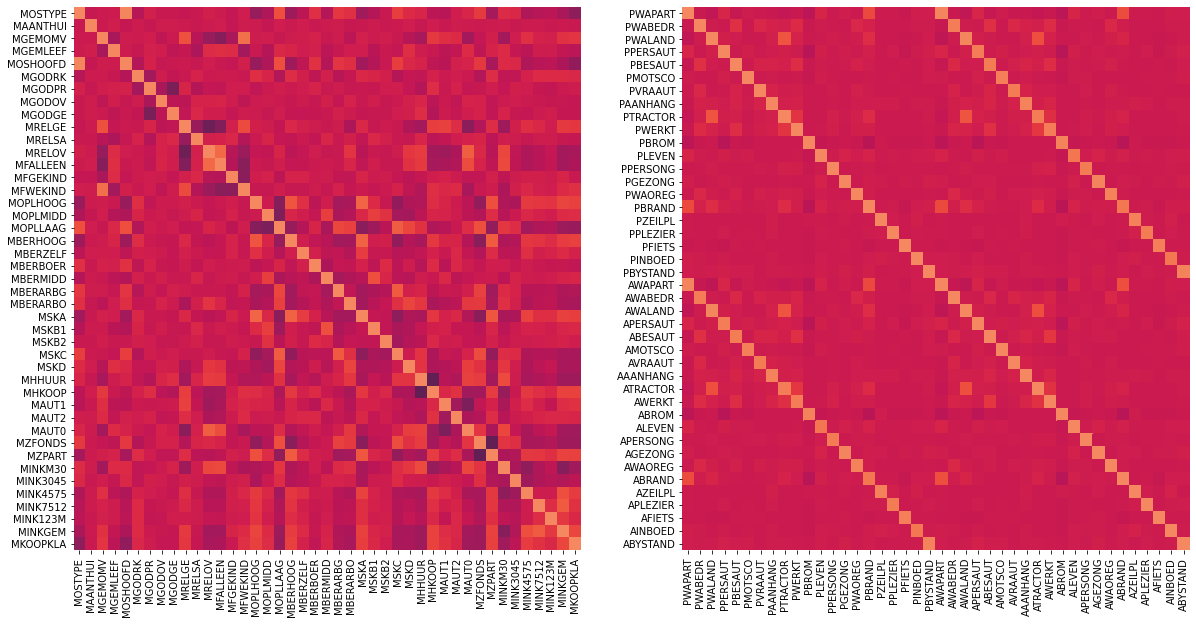

In [337]:
f,axs=plt.subplots(1,2,figsize=(20,10))
sns.heatmap(df.iloc[:,1:44].corr(),ax=axs[0],vmin=-2, vmax=2,cbar=None)
sns.heatmap(df.iloc[:,44:-1].corr(),ax=axs[1],vmin=-2, vmax=2,cbar=None)

**Based on the above observation, we can say that the data is highly imbalanced as the Caravan 0 count is very high as compared to Caravan 1. There are no null values amongst the data sets. We can also say that we have enough Train and Test data sets. There exists a good amount of correlation between the data and the categorical is high in value where as the numerical value is in low range. So, since LightGBM model has inbuild feature to deal with the categorical variables, we initiate the LightGBM model and proceed forward.** 

## **Initializing LightGBM Model and training data for it**

In [338]:
dtrain = lgbm.Dataset(X_train,
                      label=y_train,
                      categorical_feature = [1,5]
                      )

dtest = lgbm.Dataset(
                     X_test,
                     label=y_test,
                     categorical_feature = [1,5]
                    )

In [339]:
cat_col = ['MOSTYPE','MOSHOOFD']
df.pop('CARAVAN')
num_cols = list(df.columns.values[43:])
num_cols

['MKOOPKLA',
 'PWAPART',
 'PWABEDR',
 'PWALAND',
 'PPERSAUT',
 'PBESAUT',
 'PMOTSCO',
 'PVRAAUT',
 'PAANHANG',
 'PTRACTOR',
 'PWERKT',
 'PBROM',
 'PLEVEN',
 'PPERSONG',
 'PGEZONG',
 'PWAOREG',
 'PBRAND',
 'PZEILPL',
 'PPLEZIER',
 'PFIETS',
 'PINBOED',
 'PBYSTAND',
 'AWAPART',
 'AWABEDR',
 'AWALAND',
 'APERSAUT',
 'ABESAUT',
 'AMOTSCO',
 'AVRAAUT',
 'AAANHANG',
 'ATRACTOR',
 'AWERKT',
 'ABROM',
 'ALEVEN',
 'APERSONG',
 'AGEZONG',
 'AWAOREG',
 'ABRAND',
 'AZEILPL',
 'APLEZIER',
 'AFIETS',
 'AINBOED',
 'ABYSTAND']

In [340]:
params_fixed = {                           # Specify params that are fixed
                 "objective": "binary",
                 "metric": "binary_logloss",
                 "verbosity": -1,
                 "boosting_type": "gbdt",
                }


In [341]:
model = lgbm.train(
                   params_fixed,               # Just fixed params only
                   dtrain,                     # Dataset
                   valid_sets=[dtrain, dtest],  # Evaluate performance on these datasets
                   verbose_eval=100,
                   early_stopping_rounds=100,
                   categorical_feature = cat_col # columns 0 and 1 are categorical
                  )

[I 2021-08-25 14:16:41,289] A new study created in memory with name: no-name-65cc92f5-6247-40a4-98b9-d843d19ebf72
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.


feature_fraction, val_score: 0.208079:  14%|#4        | 1/7 [00:00<00:02,  2.03it/s]

[100]	valid_0's binary_logloss: 0.0724917	valid_1's binary_logloss: 0.237399
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.162392	valid_1's binary_logloss: 0.208079
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction, val_score: 0.205849:  29%|##8       | 2/7 [00:01<00:02,  1.89it/s]

[100]	valid_0's binary_logloss: 0.070999	valid_1's binary_logloss: 0.233655
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.15635	valid_1's binary_logloss: 0.205849
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction, val_score: 0.205849:  43%|####2     | 3/7 [00:01<00:01,  2.06it/s]

[100]	valid_0's binary_logloss: 0.0805475	valid_1's binary_logloss: 0.231352
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.158608	valid_1's binary_logloss: 0.20585
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction, val_score: 0.205849:  57%|#####7    | 4/7 [00:02<00:01,  1.88it/s]

[100]	valid_0's binary_logloss: 0.0698416	valid_1's binary_logloss: 0.236892
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.161295	valid_1's binary_logloss: 0.208402
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction, val_score: 0.205102:  71%|#######1  | 5/7 [00:02<00:01,  1.94it/s]

[100]	valid_0's binary_logloss: 0.0748865	valid_1's binary_logloss: 0.232411
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.152176	valid_1's binary_logloss: 0.205102
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction, val_score: 0.205102:  86%|########5 | 6/7 [00:03<00:00,  1.94it/s]

[100]	valid_0's binary_logloss: 0.0741967	valid_1's binary_logloss: 0.235765
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.158159	valid_1's binary_logloss: 0.208067
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction, val_score: 0.205102: 100%|##########| 7/7 [00:03<00:00,  1.97it/s]


[100]	valid_0's binary_logloss: 0.0781368	valid_1's binary_logloss: 0.231641
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.153048	valid_1's binary_logloss: 0.206529


num_leaves, val_score: 0.205102:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:   5%|5         | 1/20 [00:00<00:15,  1.21it/s]

[100]	valid_0's binary_logloss: 0.0244863	valid_1's binary_logloss: 0.323345
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.136124	valid_1's binary_logloss: 0.208937
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  10%|#         | 2/20 [00:01<00:16,  1.12it/s]

[100]	valid_0's binary_logloss: 0.0210779	valid_1's binary_logloss: 0.351873
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.153199	valid_1's binary_logloss: 0.210926
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  15%|#5        | 3/20 [00:02<00:15,  1.09it/s]

[100]	valid_0's binary_logloss: 0.0210779	valid_1's binary_logloss: 0.351873
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.153199	valid_1's binary_logloss: 0.210926
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  20%|##        | 4/20 [00:03<00:15,  1.06it/s]

[100]	valid_0's binary_logloss: 0.0209935	valid_1's binary_logloss: 0.35439
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.153199	valid_1's binary_logloss: 0.210926
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  25%|##5       | 5/20 [00:04<00:12,  1.15it/s]

[100]	valid_0's binary_logloss: 0.0281511	valid_1's binary_logloss: 0.307004
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.135619	valid_1's binary_logloss: 0.20994
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  30%|###       | 6/20 [00:05<00:12,  1.10it/s]

[100]	valid_0's binary_logloss: 0.0209935	valid_1's binary_logloss: 0.35439
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.153199	valid_1's binary_logloss: 0.210926
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  35%|###5      | 7/20 [00:06<00:11,  1.14it/s]

[100]	valid_0's binary_logloss: 0.0245845	valid_1's binary_logloss: 0.325584
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.136858	valid_1's binary_logloss: 0.210336
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  40%|####      | 8/20 [00:07<00:10,  1.09it/s]

[100]	valid_0's binary_logloss: 0.0209935	valid_1's binary_logloss: 0.35439
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.153199	valid_1's binary_logloss: 0.210926
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  45%|####5     | 9/20 [00:08<00:09,  1.12it/s]

[100]	valid_0's binary_logloss: 0.0221517	valid_1's binary_logloss: 0.340522
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.135119	valid_1's binary_logloss: 0.209512
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  50%|#####     | 10/20 [00:09<00:09,  1.09it/s]

[100]	valid_0's binary_logloss: 0.0211145	valid_1's binary_logloss: 0.351848
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.153199	valid_1's binary_logloss: 0.210926
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  55%|#####5    | 11/20 [00:09<00:06,  1.36it/s]

[100]	valid_0's binary_logloss: 0.184213	valid_1's binary_logloss: 0.205468
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.190321	valid_1's binary_logloss: 0.205114
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  60%|######    | 12/20 [00:09<00:04,  1.63it/s]

[100]	valid_0's binary_logloss: 0.177224	valid_1's binary_logloss: 0.207131
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.187324	valid_1's binary_logloss: 0.205633
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  65%|######5   | 13/20 [00:10<00:03,  1.89it/s]

[100]	valid_0's binary_logloss: 0.16251	valid_1's binary_logloss: 0.207762
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.180267	valid_1's binary_logloss: 0.205507
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  70%|#######   | 14/20 [00:10<00:02,  2.14it/s]

[100]	valid_0's binary_logloss: 0.192607	valid_1's binary_logloss: 0.205463
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.193228	valid_1's binary_logloss: 0.20538


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.


num_leaves, val_score: 0.205102:  75%|#######5  | 15/20 [00:10<00:02,  2.02it/s]

[100]	valid_0's binary_logloss: 0.0573458	valid_1's binary_logloss: 0.247962
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.148176	valid_1's binary_logloss: 0.207252
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  80%|########  | 16/20 [00:11<00:02,  1.93it/s]

[100]	valid_0's binary_logloss: 0.0476638	valid_1's binary_logloss: 0.263115
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.152255	valid_1's binary_logloss: 0.209976
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  85%|########5 | 17/20 [00:12<00:01,  1.86it/s]

[100]	valid_0's binary_logloss: 0.0476638	valid_1's binary_logloss: 0.263115
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.152255	valid_1's binary_logloss: 0.209976
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  90%|######### | 18/20 [00:12<00:01,  1.94it/s]

[100]	valid_0's binary_logloss: 0.080093	valid_1's binary_logloss: 0.233307
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.160691	valid_1's binary_logloss: 0.207833
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102:  95%|#########5| 19/20 [00:13<00:00,  1.77it/s]

[100]	valid_0's binary_logloss: 0.0357164	valid_1's binary_logloss: 0.28697
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.137905	valid_1's binary_logloss: 0.21057
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

num_leaves, val_score: 0.205102: 100%|##########| 20/20 [00:14<00:00,  1.42it/s]


[100]	valid_0's binary_logloss: 0.0214515	valid_1's binary_logloss: 0.350539
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.153201	valid_1's binary_logloss: 0.210925


bagging, val_score: 0.205102:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102:  10%|#         | 1/10 [00:00<00:04,  2.04it/s]

[100]	valid_0's binary_logloss: 0.0865113	valid_1's binary_logloss: 0.24299
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.17661	valid_1's binary_logloss: 0.210432
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102:  20%|##        | 2/10 [00:01<00:04,  1.90it/s]

[100]	valid_0's binary_logloss: 0.0763175	valid_1's binary_logloss: 0.234512
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.153106	valid_1's binary_logloss: 0.207122
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102:  30%|###       | 3/10 [00:01<00:03,  1.90it/s]

[100]	valid_0's binary_logloss: 0.0778273	valid_1's binary_logloss: 0.23436
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.164688	valid_1's binary_logloss: 0.20778
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102:  40%|####      | 4/10 [00:02<00:03,  1.87it/s]

[100]	valid_0's binary_logloss: 0.074157	valid_1's binary_logloss: 0.234845
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.155315	valid_1's binary_logloss: 0.207367
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102:  50%|#####     | 5/10 [00:02<00:02,  1.83it/s]

[100]	valid_0's binary_logloss: 0.0749922	valid_1's binary_logloss: 0.234833
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.154968	valid_1's binary_logloss: 0.206971
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102:  60%|######    | 6/10 [00:03<00:02,  1.90it/s]

[100]	valid_0's binary_logloss: 0.0863012	valid_1's binary_logloss: 0.241565
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.177491	valid_1's binary_logloss: 0.210341
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102:  70%|#######   | 7/10 [00:03<00:01,  1.87it/s]

[100]	valid_0's binary_logloss: 0.0775646	valid_1's binary_logloss: 0.234812
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.152201	valid_1's binary_logloss: 0.207264
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102:  80%|########  | 8/10 [00:04<00:01,  1.96it/s]

[100]	valid_0's binary_logloss: 0.0861219	valid_1's binary_logloss: 0.243072
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.170872	valid_1's binary_logloss: 0.20818
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102:  90%|######### | 9/10 [00:04<00:00,  1.97it/s]

[100]	valid_0's binary_logloss: 0.0816166	valid_1's binary_logloss: 0.24025
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.161208	valid_1's binary_logloss: 0.209462
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

bagging, val_score: 0.205102: 100%|##########| 10/10 [00:05<00:00,  1.90it/s]


[100]	valid_0's binary_logloss: 0.0765579	valid_1's binary_logloss: 0.235473
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.154503	valid_1's binary_logloss: 0.207276


feature_fraction_stage2, val_score: 0.205102:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction_stage2, val_score: 0.205102:  17%|#6        | 1/6 [00:00<00:02,  1.87it/s]

[100]	valid_0's binary_logloss: 0.0749776	valid_1's binary_logloss: 0.23215
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.146761	valid_1's binary_logloss: 0.206564
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction_stage2, val_score: 0.205102:  33%|###3      | 2/6 [00:01<00:01,  2.02it/s]

[100]	valid_0's binary_logloss: 0.0780427	valid_1's binary_logloss: 0.235087
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.154281	valid_1's binary_logloss: 0.207131
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction_stage2, val_score: 0.205102:  50%|#####     | 3/6 [00:01<00:01,  1.97it/s]

[100]	valid_0's binary_logloss: 0.0735268	valid_1's binary_logloss: 0.235223
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.147384	valid_1's binary_logloss: 0.207738
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction_stage2, val_score: 0.205102:  67%|######6   | 4/6 [00:02<00:00,  2.02it/s]

[100]	valid_0's binary_logloss: 0.0776345	valid_1's binary_logloss: 0.231236
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.152458	valid_1's binary_logloss: 0.206558
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction_stage2, val_score: 0.205102:  83%|########3 | 5/6 [00:02<00:00,  2.00it/s]

[100]	valid_0's binary_logloss: 0.0755215	valid_1's binary_logloss: 0.233245
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.154368	valid_1's binary_logloss: 0.207059
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction_stage2, val_score: 0.205102: 100%|##########| 6/6 [00:03<00:00,  2.00it/s]


[100]	valid_0's binary_logloss: 0.0766742	valid_1's binary_logloss: 0.233192
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.15107	valid_1's binary_logloss: 0.206196


regularization_factors, val_score: 0.205102:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:   5%|5         | 1/20 [00:00<00:08,  2.17it/s]

[100]	valid_0's binary_logloss: 0.122519	valid_1's binary_logloss: 0.21542
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.172984	valid_1's binary_logloss: 0.207639
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  10%|#         | 2/20 [00:00<00:08,  2.09it/s]

[100]	valid_0's binary_logloss: 0.0748924	valid_1's binary_logloss: 0.230767
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.152176	valid_1's binary_logloss: 0.205102
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  15%|#5        | 3/20 [00:01<00:08,  2.07it/s]

[100]	valid_0's binary_logloss: 0.0757238	valid_1's binary_logloss: 0.234093
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.157115	valid_1's binary_logloss: 0.205905
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  20%|##        | 4/20 [00:01<00:07,  2.04it/s]

[100]	valid_0's binary_logloss: 0.0810633	valid_1's binary_logloss: 0.227978
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.147339	valid_1's binary_logloss: 0.207452
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  25%|##5       | 5/20 [00:02<00:07,  2.02it/s]

[100]	valid_0's binary_logloss: 0.0742179	valid_1's binary_logloss: 0.230571
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.152187	valid_1's binary_logloss: 0.205102
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  30%|###       | 6/20 [00:02<00:06,  2.06it/s]

[100]	valid_0's binary_logloss: 0.0761752	valid_1's binary_logloss: 0.23323
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.158247	valid_1's binary_logloss: 0.207712
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  35%|###5      | 7/20 [00:03<00:06,  2.02it/s]

[100]	valid_0's binary_logloss: 0.0863771	valid_1's binary_logloss: 0.227588
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.157991	valid_1's binary_logloss: 0.206646
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  40%|####      | 8/20 [00:03<00:05,  2.03it/s]

[100]	valid_0's binary_logloss: 0.0748956	valid_1's binary_logloss: 0.230762
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.152178	valid_1's binary_logloss: 0.205102
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  45%|####5     | 9/20 [00:04<00:05,  2.01it/s]

[100]	valid_0's binary_logloss: 0.0860984	valid_1's binary_logloss: 0.227309
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.1624	valid_1's binary_logloss: 0.208991
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  50%|#####     | 10/20 [00:04<00:05,  2.00it/s]

[100]	valid_0's binary_logloss: 0.081277	valid_1's binary_logloss: 0.227885
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.155841	valid_1's binary_logloss: 0.207322
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  55%|#####5    | 11/20 [00:05<00:04,  1.98it/s]

[100]	valid_0's binary_logloss: 0.0746953	valid_1's binary_logloss: 0.23154
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.152179	valid_1's binary_logloss: 0.205102
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  60%|######    | 12/20 [00:05<00:04,  1.98it/s]

[100]	valid_0's binary_logloss: 0.074698	valid_1's binary_logloss: 0.231537
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.152181	valid_1's binary_logloss: 0.205102
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205102:  65%|######5   | 13/20 [00:06<00:03,  1.98it/s]

[100]	valid_0's binary_logloss: 0.0752245	valid_1's binary_logloss: 0.236783
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.159439	valid_1's binary_logloss: 0.206961
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205100:  70%|#######   | 14/20 [00:06<00:02,  2.00it/s]

[100]	valid_0's binary_logloss: 0.0758165	valid_1's binary_logloss: 0.233173
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.152202	valid_1's binary_logloss: 0.2051
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205100:  75%|#######5  | 15/20 [00:07<00:02,  2.02it/s]

[100]	valid_0's binary_logloss: 0.074953	valid_1's binary_logloss: 0.231917
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.157193	valid_1's binary_logloss: 0.205896
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205100:  80%|########  | 16/20 [00:07<00:01,  2.00it/s]

[100]	valid_0's binary_logloss: 0.0765145	valid_1's binary_logloss: 0.232215
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.15978	valid_1's binary_logloss: 0.207232
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205100:  85%|########5 | 17/20 [00:08<00:01,  2.02it/s]

[100]	valid_0's binary_logloss: 0.0743939	valid_1's binary_logloss: 0.231639
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.152176	valid_1's binary_logloss: 0.205102
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205100:  90%|######### | 18/20 [00:08<00:01,  1.99it/s]

[100]	valid_0's binary_logloss: 0.0741756	valid_1's binary_logloss: 0.231621
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.152191	valid_1's binary_logloss: 0.205101
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205100:  95%|#########5| 19/20 [00:09<00:00,  2.02it/s]

[100]	valid_0's binary_logloss: 0.0768252	valid_1's binary_logloss: 0.235609
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.155756	valid_1's binary_logloss: 0.206525
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

regularization_factors, val_score: 0.205100: 100%|##########| 20/20 [00:09<00:00,  2.01it/s]


[100]	valid_0's binary_logloss: 0.0760331	valid_1's binary_logloss: 0.233951
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.153268	valid_1's binary_logloss: 0.207693


min_data_in_leaf, val_score: 0.205100:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

min_data_in_leaf, val_score: 0.205100:  20%|##        | 1/5 [00:00<00:01,  2.07it/s]

[100]	valid_0's binary_logloss: 0.0780536	valid_1's binary_logloss: 0.234523
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.158206	valid_1's binary_logloss: 0.206817
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

min_data_in_leaf, val_score: 0.205100:  40%|####      | 2/5 [00:01<00:01,  1.99it/s]

[100]	valid_0's binary_logloss: 0.0936231	valid_1's binary_logloss: 0.228082
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.164826	valid_1's binary_logloss: 0.205389
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

min_data_in_leaf, val_score: 0.205100:  60%|######    | 3/5 [00:01<00:00,  2.02it/s]

[100]	valid_0's binary_logloss: 0.0745331	valid_1's binary_logloss: 0.235281
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.155423	valid_1's binary_logloss: 0.20758
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

min_data_in_leaf, val_score: 0.205100:  80%|########  | 4/5 [00:01<00:00,  2.03it/s]

[100]	valid_0's binary_logloss: 0.070474	valid_1's binary_logloss: 0.231008
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.143011	valid_1's binary_logloss: 0.207333
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['MOSHOOFD', 'MOSTYPE']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

min_data_in_leaf, val_score: 0.205100: 100%|##########| 5/5 [00:02<00:00,  2.01it/s]

[100]	valid_0's binary_logloss: 0.0851461	valid_1's binary_logloss: 0.232157
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.159286	valid_1's binary_logloss: 0.20672


In [342]:
model.predict(
                X_test,    # Note that it is not lightgbm dataset
                num_iteration = model.best_iteration
             )

array([0.02053433, 0.47839073, 0.11213303, ..., 0.06491371, 0.11203761,
       0.05342784])

In [343]:
prediction = np.rint(
                     model.predict(
                                    X_test,    # Note that it is not lightgbm dataset
                                    num_iteration = model.best_iteration
                                    )
                    )

# 4.0.1
prediction

array([0., 0., 0., ..., 0., 0., 0.])

In [344]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, prediction)

# 4.2 Get best params
best_params = model.params
print("\nbest_params: " ,best_params) 
print("\n===============")
print("\nAccuracy: ", accuracy)
print("\n===============")

# 4.3
for key, value in best_params.items():
    print("\n    {}: {}".format(key, value))

######################


best_params:  {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.3204464670634513e-05, 'lambda_l2': 0.0023271863128646584, 'num_leaves': 31, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}


Accuracy:  0.94075


    objective: binary

    metric: binary_logloss

    verbosity: -1

    boosting_type: gbdt

    feature_pre_filter: False

    lambda_l1: 1.3204464670634513e-05

    lambda_l2: 0.0023271863128646584

    num_leaves: 31

    feature_fraction: 0.6

    bagging_fraction: 1.0

    bagging_freq: 0

    min_child_samples: 20


## **Using Bayesian Optimization on LGBM Classifier**

**Model**

In [345]:
model_lgb = lgb.LGBMClassifier(               
                                objective='binary',
                                metric='auc',
                                n_jobs=2,
                                verbose=1,
                              )

In [346]:
ct = ColumnTransformer(
                        [
                          ("ct", OneHotEncoder(sparse = False), cat_col),
                          ("ss", StandardScaler(), num_features)
                        ],
                       remainder = "passthrough"
                      )


In [347]:
ct.fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [348]:
pipe = Pipeline(
                  [
                    ("cx", ct),
                    ("lgb", model_lgb)
                  ]
                )

# 5.1.1
print(pipe.get_params())

{'memory': None, 'steps': [('cx', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('ct',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=False),
                                 ['MOSTYPE', 'MOSHOOFD']),
                                ('ss',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                  15, 16, 17, 18, 19, 20, 21, 22, 23, 24])],
                  verbose=False)), ('lgb', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
    

In [349]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cx',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ct',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=False),
                                                  ['MOSTYPE', 'MOSHOOFD']),
                                                 ('ss',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,

**Defining Parameters**

In [350]:
params = {
        # The 'boosting' option parameter give lots of errors. 
        # Do not use it. (Removed 'rf' from it. Avoids errors)
        'lgb__boosting'    :   Categorical(['gbdt','dart']),                                                         
        'lgb__n_estimators':   Integer(50, 100), # No of boosted trees or iterations to fit (default: 100).

        'lgb__num_leaves'  :   Integer(5,45),   # Max tree leaves for base boosters
                                           # Create a node only if no of leaves exceed this limit
                                           #  and also following condition of 'min_child_samples' is met

        'lgb__min_child_samples': Integer(1, 50),  # Create a node only if min data-points at this node
                                              #  exceed this limit

        'lgb__feature_fraction' : Real(0.1, 0.9),  # Randomly select part of features on each iteration
                                              #  for every boosted tree

        'lgb__bagging_fraction' : Real(0.8, 1),   # Randomly select part of data without resampling
                                             #   for each boosted tree

        'lgb__bagging_freq'     : Integer(1,10),  # k means perform bagging at every k iteration

        'lgb__max_depth'        : Integer(1, 50), # Max tree depth for base learners, -1 means no limit.

        'lgb__learning_rate': Real(0.01, 1.0, 'log-uniform'), # Prob of interval 1 to 10 is same as 10 to 100
                                                         # Equal prob of selection from 0.01 to 0.1, 0.1
                                                         # to 1
                                                         # In a loguniform distributon, log-transformed
                                                         # random variable is uniformly distributed

        'lgb__reg_lambda': Real(1e-9, 1000, 'log-uniform'),  # L2 regularization term on weights.
        'lgb__reg_alpha':  Real(1e-9, 1.0, 'log-uniform'),   #  L1 regularization

        'lgb__scale_pos_weight': Real(1, 10),    # default: 1
                                            # used only in binary application
                                            # How much more importance should be given to binary
                                            # weight of labels with positive class

        #-----***** Not understood **** -----

        'lgb__max_bin': Integer(100, 1000),      # max number of bins that feature
                                            #  values will be bucketed in
                                            # small number of bins may reduce
                                            # training accuracy but may increase
                                            # general power (deal with over-fitting)

        'lgb__min_child_weight':  Real(1, 10),   # Deals with overfitting

        'lgb__subsample_for_bin': Integer(100000, 500000)  #  Number of samples for constructing bins(default: 200000)
                                               # setting this to larger value will give better training
                                               #  result, but will increase data loading time
           }


**Cross Validation**

In [351]:
cvStrategy = StratifiedKFold(
                             n_splits=3,
                             shuffle=True,
                             random_state=42
                            )

**Bayes Tuner Object**

In [352]:
import os, time
start = time.time()
bayes_cv_tuner = BayesSearchCV(
                              estimator = pipe,    # rf, lgb, xgb, nn , pipeline etc--Black box
                              search_spaces = params,  # Specify params as required by the estimator
                              scoring = 'roc_auc',  # Input to Bayes function
                                                    # modeler should return this
                                                    # peformence metric
                              cv = cvStrategy,      # Optional. Determines the cross-validation splitting strategy.
                                                    #           Can be cross-validation generator or an iterable,
                                                    #           Possible inputs for cv are: - None, to use the default 3-fold cv,
                                                    #           - integer, to specify the number of folds in a (Stratified)KFold,
                                                    #           - An object to be used as a cross-validation generator.
                              n_jobs = 2,           # Start two parallel threads for processing
                              n_iter = 10,        # How many times to look for parameter sets
                              verbose = 1,
                              refit = True,       #  Refit the best estimator with the entire dataset
                              random_state = 42
                               )
end = time.time()
(end-start)/60

3.0835469563802084e-06

## **Tuning of HyperParameters**

In [353]:
start = time.time()
result = bayes_cv_tuner.fit(
                            X_train,y_train
                           )

end = time.time()
(end - start)/60

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   15.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    9.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    9.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   13.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   11.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    2.6s finished


1.3412177522977193

## **Results**

In [354]:
best_params = pd.Series(bayes_cv_tuner.best_params_)
print(best_params)

# 6.1 Best auc score for the above estimator

print("\n\nBest score: ", np.round(bayes_cv_tuner.best_score_, 4))

lgb__bagging_fraction        0.991096
lgb__bagging_freq                   7
lgb__boosting                    gbdt
lgb__feature_fraction        0.432657
lgb__learning_rate          0.0578268
lgb__max_bin                      290
lgb__max_depth                      1
lgb__min_child_samples             19
lgb__min_child_weight         6.34941
lgb__n_estimators                  59
lgb__num_leaves                    36
lgb__reg_alpha            9.99117e-06
lgb__reg_lambda           3.13312e-08
lgb__scale_pos_weight         2.66614
lgb__subsample_for_bin         247054
dtype: object


Best score:  0.7563


In [355]:
mod = lgb.LGBMClassifier(               
                                objective=None,
                                n_jobs=2,
                                verbose=1,
                                bagging_fraction=0.991096,bagging_freq=7,boosting='gbdt',feature_fraction=0.432657,learning_rate=0.0578268,max_bin=290,
max_depth=1,
min_child_samples=19,
min_child_weight=6.34941,
n_estimators=59,
num_leaves=36,
reg_alpha=9.99117e-06,
reg_lambda=3.13312e-08,
scale_pos_weight=2.66614,
subsample_for_bin=247054,
                              )

In [356]:
mod.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.991096, bagging_freq=7, boosting='gbdt',
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.432657, importance_type='split',
               learning_rate=0.0578268, max_bin=290, max_depth=1,
               min_child_samples=19, min_child_weight=6.34941,
               min_split_gain=0.0, n_estimators=59, n_jobs=2, num_leaves=36,
               objective=None, random_state=None, reg_alpha=9.99117e-06,
               reg_lambda=3.13312e-08, scale_pos_weight=2.66614, silent=True,
               subsample=1.0, subsample_for_bin=247054, subsample_freq=0,
               verbose=1)

## **Checking Accuracy**

In [357]:
y_pred=mod.predict(X_test)

In [358]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9407


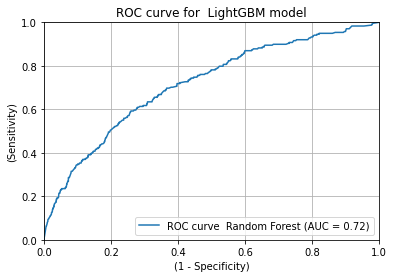

In [359]:
from sklearn.metrics import roc_curve, auc
lgbm_pred_prob = mod.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, lgbm_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve  Random Forest (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for  LightGBM model')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

## **Final Potential Customers Based on Test Data**

In [360]:
test_target = y_test.copy()
test_target.reset_index(drop=True, inplace=True)
test_target=test_target.replace({
    1:'Yes',
    0:'No'
})
predicted_target=mod.predict(X_test)
predicted_target=pd.Series(predicted_target).replace({
    1:'Yes',
    0:'No'
})

In [361]:
ranks=pd.DataFrame(data={
    'rank':lgbm_pred_prob
})
ranks.sort_values(by=['rank'],ascending=False,inplace=True)
ranks.head()

,rank
2621,0.546682
575,0.537651
1995,0.531016
291,0.391406
3499,0.390049


In [362]:
top = ranks.where(ranks['rank']>0.5,).dropna()
top.head()

,rank
2621,0.546682
575,0.537651
1995,0.531016


In [363]:
top.shape

(3, 1)

## **We can conclude that the LightGBM model along with Optuna tuning is not the right way to go for this model as the final outputs are only 3 that can be seen. A better classifier model can be used to finalize on the potential customers for the Caravan Insurance Challenge**